<a href="https://colab.research.google.com/github/gackouhamady/MLSD-25-26-Courses/blob/main/01-Data-Engineering/BI/notebooks/03_Data_Sampling_Distributions_R_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Sampling Distributions**



In [ ]:
if (!require(boot)) install.packages('boot')
if (!require(ggplot2)) install.packages('ggplot2')

In [ ]:
library(boot)
library(ggplot2)

# Illustrating the *central limit theorem*

$\underline{Central~limit~theorem}$ : the means drawn from multiple samples will resemble the familiar bell-shaped normal curve, even if the population is not normally
distributed, provided that:<br>
- the sample size is large enough<br>
- the departure of the data from normality is not too great

In [ ]:
# Load the data
loans_income <- read.csv(file.path('sample_data', 'loans_income.csv'))
dim(loans_income); head(loans_income)

[1] 50000     1

,x
,<int>
1,67000
2,52000
3,100000
4,78762
5,37041
6,33000


In [ ]:
# convert data frame to vector
loans_income <- loans_income[, 1]

In [ ]:
# take a simple random sample
samp_data <- data.frame(income=sample(loans_income, 1000),
                        type='data_dist')

# take a sample of means of 5 values
samp_mean_05 <- data.frame(
  income = tapply(sample(loans_income, 1000*5), rep(1:1000, rep(5, 1000)), FUN=mean), type = 'mean_of_5')

# take a sample of means of 20 values
samp_mean_20 <- data.frame(
  income = tapply(sample(loans_income, 1000*20),
                  rep(1:1000, rep(20, 1000)), FUN=mean),
  type = 'mean_of_20')

# bind the data.frames and convert type to a factor
income <- rbind(samp_data, samp_mean_05, samp_mean_20)
income$type <- factor(income$type,
                     levels=c('data_dist', 'mean_of_5', 'mean_of_20'),
                     labels=c('Data', 'Mean of 5', 'Mean of 20'))
head(income)

,income,type
,<dbl>,<fct>
1,80000,Data
2,73200,Data
3,70000,Data
4,127000,Data
5,25800,Data
6,60000,Data


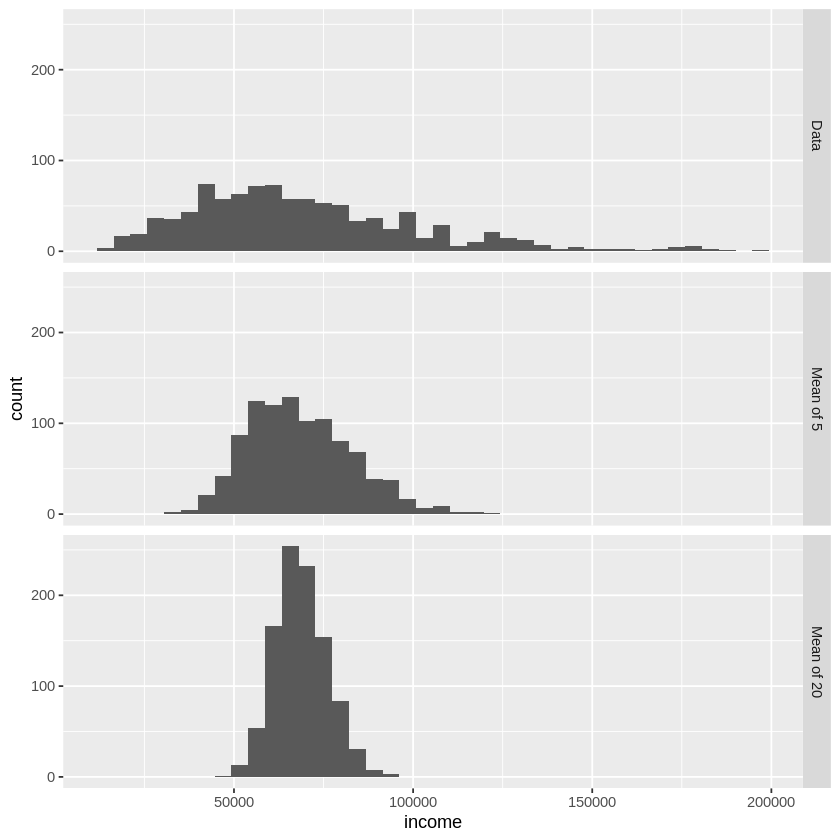

In [ ]:
ggplot(income, aes(x=income)) +
  geom_histogram(bins=40) +
  facet_grid(type ~ .)

# The Bootstrap

$\underline{Objective}$ : estimate the sampling distribution of a statistic, or of model parameters<br>

$\underline{How?}$ : draw additional samples, with replacement, from the sample itself and recalculate the statistic or model for each resample

$\underline{Why?}$ :
- a model might be run on the bootstrapped data to estimate the stability (**variability**) of model parameters
- running multiple trees on bootstrap samples and then averaging their predictions generally performs better than using a single tree (**bagging**)

Algorithm for a **bootstrap resampling** of the **mean** (sample size $n$):<br>
 1. Draw a sample value, record it, and then replace it.
 2. Repeat $n$ times.
 3. Record the mean of the $n$ resampled values.
 4. Repeat steps 1-3 $R$ times.
 5. Use the $R$ results to:<br>
  a. Calculate their standard deviation *(this estimates sample mean standard error $=SE=\frac{s}{\sqrt{n}}$*).<br>
  b. Produce a histogram or boxplot.<br>
  c. Find a confidence interval.

In [ ]:
# Apply bootstrap to the incomes of people taking out loans
stat_fun <- function(x, idx) median(x[idx])
boot_obj <- boot(loans_income, R=1000, statistic=stat_fun)

boot_obj

# Bias: difference between the mean of the statistic estimates and the population value
# In our example: the average median across 1,000 experiments under-estimates the population median.
# For one sample, we can correct for the bias: sample median – (mean of bootstrap estimates – sample median)
# More explanations on bias here: https://garstats.wordpress.com/2018/01/23/bias-correction/


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = loans_income, statistic = stat_fun, R = 1000)


Bootstrap Statistics :
    original  bias    std. error
t1*    62000 -81.787    224.4373

# Confidence intervals

$\underline{90\%~Confidence~Interval}$ : it is the interval that encloses the central $90\%$of the bootstrap sampling distribution of a sample statistic<br>

Algorithm for a **bootstrap confidence interval** (sample size $n$):<br>
 1. Draw a random sample of size $n$ with replacement from the data.
 2. Record the statistic of interest for the resample.
 3. Repeat steps 1-2 many (R) times.
 4. For an $x\%$ confidence interval, trim [(100-$x$) / 2]\% of the $R$ resample results from either end of the distribution.
 5. The trim points are the endpoints of an $x\%$ bootstrap confidence interval.

In [ ]:
set.seed(5)
set.seed(7)
# Let's draw a small sample of 20 individuals
sample20 <- sample(loans_income, 20)
sampleMean <- mean(sample20)
print(sampleMean)

[1] 58447.25


In [ ]:
# Compute a boostrap for the sample mean
stat_fun <- function(x, idx) mean(x[idx])
boot_obj <- boot(sample20, R=500, statistic=stat_fun)

# Get the confidence interval
boot_ci <- boot.ci(boot_obj, conf=0.9, type='basic')
X <- data.frame(mean=boot_obj$t)

ci90 <- boot_ci$basic[4:5]
ci <- data.frame(ci=ci90, y=c(9, 11))

ci,y
<dbl>,<dbl>
51643.09,9
65262.95,11


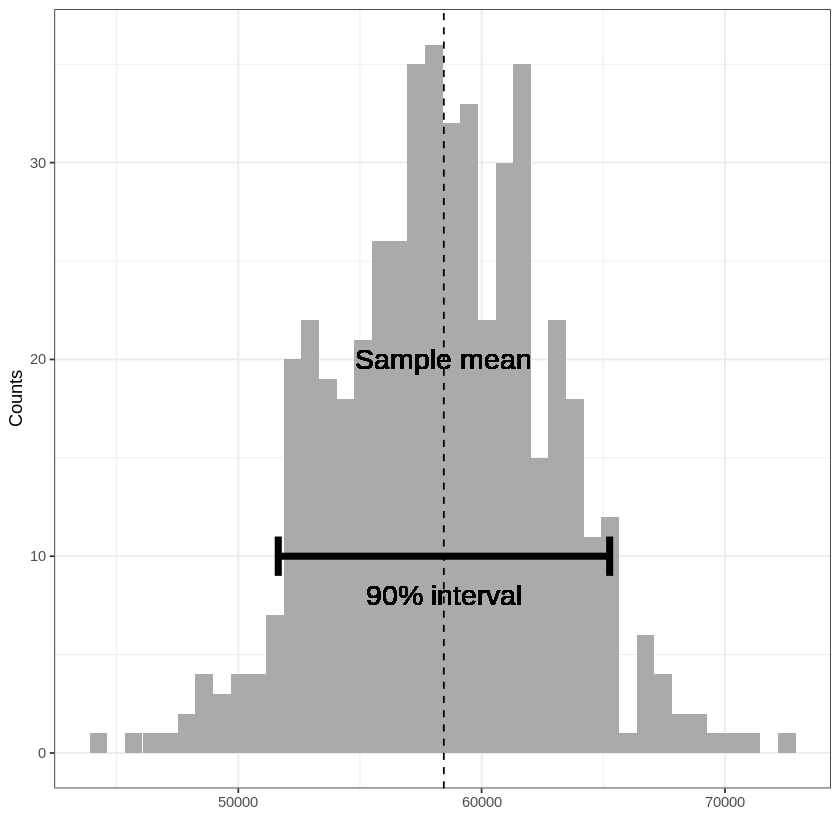

In [ ]:
ci
ggplot(X, aes(x=mean)) +
    geom_histogram(bins=40, fill='#AAAAAA') +
    geom_vline(xintercept=sampleMean, linetype=2) +
    geom_path(aes(x=ci, y=10), data=ci, size=2) +
    geom_path(aes(x=ci90[1], y=y), data=ci, size=2) +
    geom_path(aes(x=ci90[2], y=y), data=ci, size=2) +
    geom_text(aes(x=sampleMean, y=20, label='Sample mean'), size=6) +
    geom_text(aes(x=sampleMean, y=8, label='90% interval'), size=6) +
    theme_bw() +
    labs(x='', y='Counts')

# NB:
# - the smaller the sample, the wider the interval (i.e. the greater the uncertainty)
# - the higher the level of confidence ($x\%$), the wider the interval

# Normal distribution

### Standard Normal and QQ-Plots

$\underline{Standard~normal}$ distribution is a normal distribution with $mean=0$ and $standard~ deviation=1$.

$\underline{Standardization}$ : you subtract the mean and divide by the standard deviation. The transformed value is named *z-score*.

A $\underline{QQ-Plot}$ is used to *visually* determine how close a sample is to a specified distribution, here the normal distribution.

$\underline{How?}$<br>
- z-scores are ordered from low to high and plots each value's z-score on the y-axis.
- x-axis corresponds to quantile of a normal distribution for that value's rank.
- since the data is normalized, the units correspond to the number of standard deviation away from the mean.

If the points roughly fall on the diagonal line, then the sample distribution can be considered close to normal.

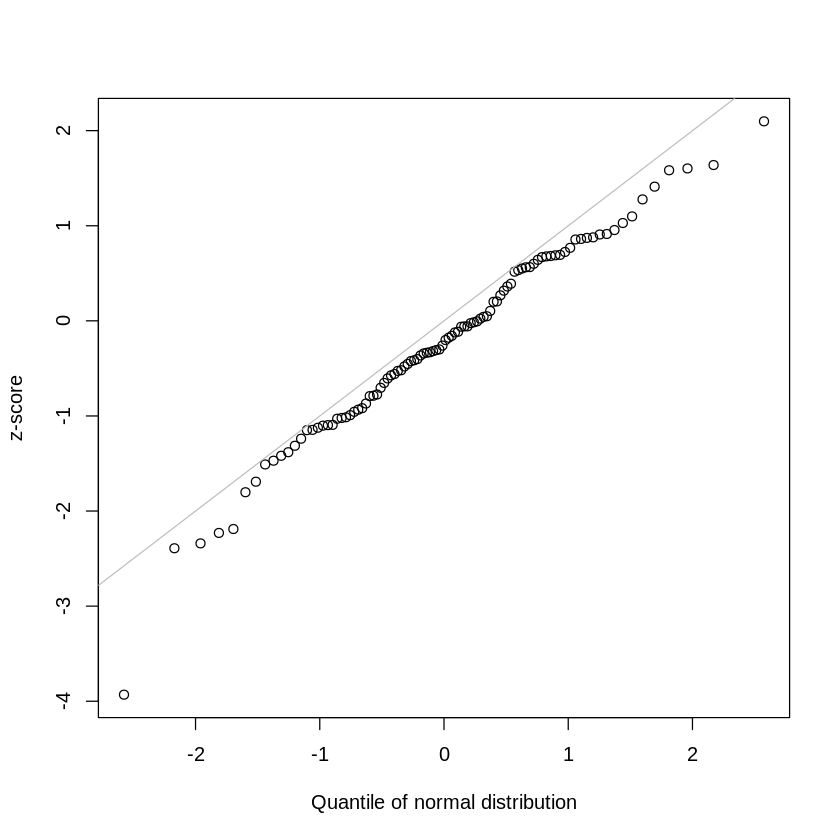

In [ ]:
# QQ-Plot for a sample of 100 values randomly generated from a normal distribution
# - the points closely follow the line
norm_samp <- rnorm(100)
qqnorm(norm_samp, main='', xlab='Quantile of normal distribution', ylab='z-score')
abline(a=0, b=1, col='grey')

# NB:
# Raw data is typically not normally distributed, errors often are, as are
# average and totals in large samples

# Long-tailed distributions

The data distribution can be highly *skewed* (asymmetric) and have a long *tail*. Symmetric distribution can also have long tails.

In [ ]:
# QQ-Plot for the daily stock returns for Netflix (NFLX)
sp500_px <- read.csv(file.path('sample_data', 'sp500_data.csv'), row.names=1)

Warning message in file(file, "rt"):
“cannot open file 'sample_data/sp500_data.csv': No such file or directory”


ERROR: ignored

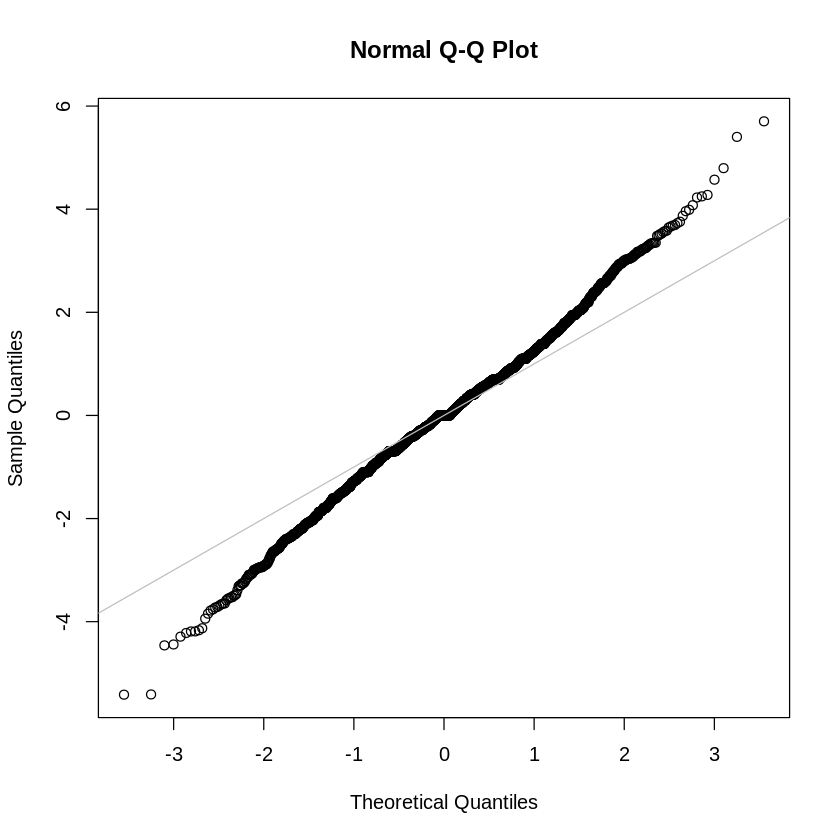

In [ ]:
nflx <- sp500_px[,'NFX']
nflx <- diff(log(nflx[nflx>0]))
qqnorm(nflx)
abline(a=0, b=1, col='grey')

# NB:
# - the points are far below the line for low values and far above the line
#  for high values
# => the data are not normally distributed, ie. we are much more likely to
# observe extreme values than would be expected if the data had a normal
# distribution

# Student's t-distribution

It is a normally shaped distribution, but a bit thicker and longer on tails. Distribution of sample means are typically shaped like a t-distribution. The larger the sample, the more normally shaped the t-distribution becomes.

# Binomial distribution

Flipping a coin 10 times is a binomial experiment with 10 *trials*. Each trial has two possible outcomes, heads or tails (*binary* outcomes). Any probabilities that some to $1$ are possible.

The **binomial distribution** is the frequency distribution of the number of successes ($x=1$) in a given number of trials ($n$) with specified probability ($p$) of success in each trial.

With large $n$, and provided $p$ is not too close to 0 or 1, the binomial distribution can be approximated by the normal distribution.

In [ ]:
# Question:
# If the probability of a click converting to a sale is 0.02, what is the
# probability of observing 0 sales in 2000 clicks?
dbinom(x=0, size=200, p=0.02)

# NB: the probability is 0.0176
# - 0 successes
# - 5 trials
# - probability of sucess is 0.02

In [ ]:
# Question:
# What is the probability of x = 2 or fewer sucesses in n=5 trials, where the
# probability of success for each trial is 0.1.
pbinom(2, 5, 0.1)

[1] 0.99144

[1] 0.0729

In [ ]:
# NB:
dbinom(2, 5, 0.1)

# Poisson and related distribution

$\underline{Poisson~distribution}$ ~The frequency distribution of the number of events in sampled units of time or space.<br>

$\underline{Exponential~distribution}$ ~The frequency distribution of the time or distance from one event to the next event.

Events occuring randomly at a given overall rate ($λ$):
- visitors arriving at a website
- imperfections in a square meter fabric
- typos per 100 lines of code



In [ ]:
rpois(100, lambda=2)

# This code generate 100 random numbers from a Poisson distribution with
# $\lambda=2$. $\lambda$ is the mean and the variance for a Poisson distribution.
#
# Example: if incoming customer service calls average 2 per minute, this code will
# simulate 100 minutes, returning hte number of calls in each of those 100 minutes.

[1] 4 1 2 3 1 1 2 2 4 0 1 2 2 3 0 4 2 0 2 0 1 4 3 0 1 2 1 2 2 3 3 0 1 2 3 3 0
 [38] 2 4 0 0 1 3 2 2 4 1 2 2 0 0 1 1 3 1 3 0 4 0 1 1 1 1 1 4 2 5 4 1 2 1 2 2 2
 [75] 0 0 2 0 3 1 2 0 2 3 4 0 2 3 3 2 2 2 1 2 2 2 3 1 2 2

In [ ]:
rexp(n=100, rate=.2)

# Thie code generate 100 random numbers from an exponential distribution where
# the mean number of events per time period is 0.2.
#
# Example: it simulates 100 intervals, in minutes, between service calls, where
# the average rate of incoming calls is 0.2 per minute.

[1]  3.3013692  2.7008112  3.8918434  1.2800474  3.4081038 13.6568560
  [7]  0.4500097 17.5182753  7.2923264  0.9744168  5.8971586 10.3342533
 [13]  2.5697235  1.8754789  1.9963461  4.6293721  3.9337463  7.0057590
 [19]  1.6292837 10.5233373  3.1910565 11.5884624 10.1933230  1.5537506
 [25] 12.8485934  2.3333340 10.7446350  3.0349711  2.5830233  9.3825617
 [31]  5.3805730  0.2552115  5.3331437  4.0720820  3.1770495  0.2040655
 [37]  0.4916450  8.6308120  3.3456279  2.8999936  1.8675758  5.7761573
 [43]  5.2304280  9.9854959  7.1503021  3.7502729  1.8934670  3.1918334
 [49]  5.6744253  8.3658204 15.4368094  0.4376550  2.8123563  7.0405204
 [55]  7.5414375 11.6651828  8.3396505  1.8878161  2.8275720 15.7462011
 [61]  6.1913881  2.8709424  3.5041390  1.4640565  7.3789836  2.1598081
 [67]  4.5531958  1.0681899  4.8489365  0.9926413  6.4706075  1.9306919
 [73]  5.8385651  6.1879940  7.8090995  5.8446768  3.6962662  1.7182389
 [79]  4.6894627  5.4156746  0.4322465  6.0355147  5.5615366  1.8576555
 [85]  6.9602512  2.5352788  0.4209624 16.1185215  1.3319390  0.1907212
 [91]  1.4235816  5.6806036 11.6778293  2.9652440  7.1725655  2.3678535
 [97]  0.5938001  2.4498349  8.1628194  6.6744746